In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos del archivo JSON
file_path = "/Users/carlosedm10/projects/college/PTEL/data.json"
file_path_2 = "/Users/carlosedm10/projects/college/PTEL/data_2.json"
with open(file_path, "r", encoding="utf-8-sig") as file:
    data = json.load(file)

# Convertir los datos a un DataFrame
df = pd.DataFrame(data)

with open(file_path_2, "r", encoding="utf-8-sig") as file:
    data_2 = json.load(file)

# Convert the JSON data to a DataFrame
df_2 = pd.DataFrame(data_2)

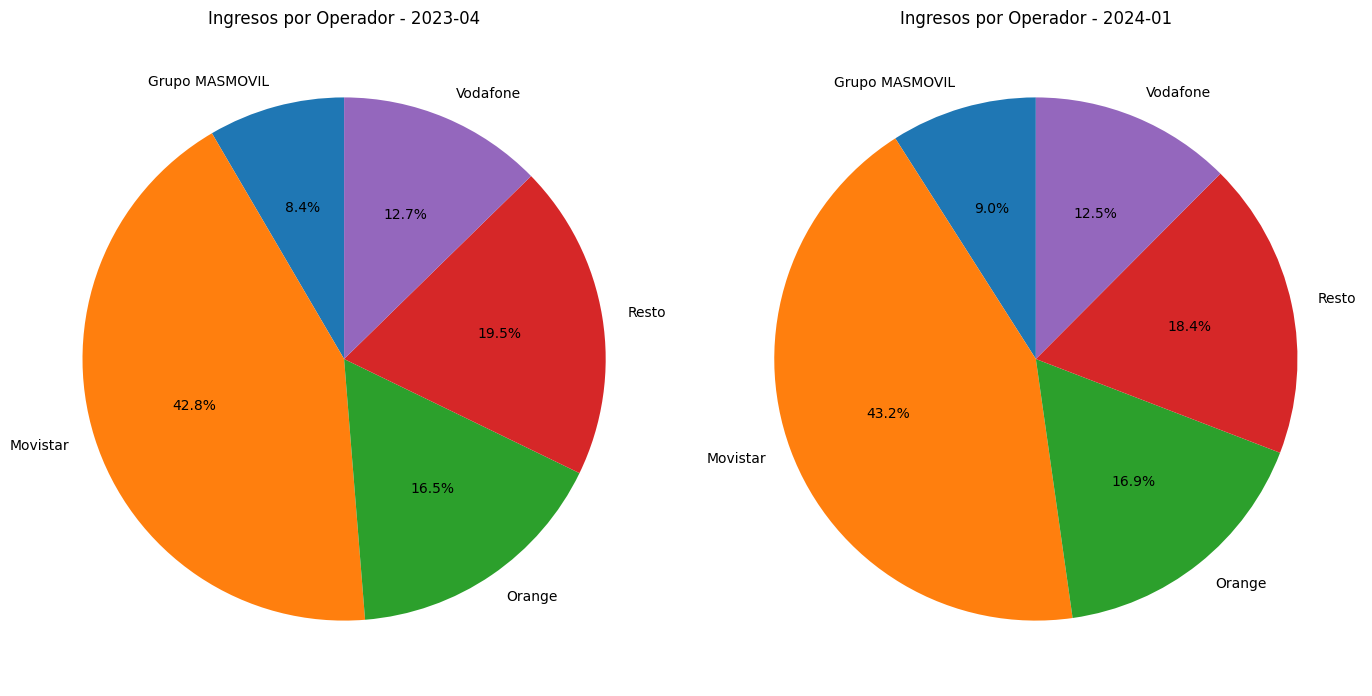

In [2]:
# Filtrar las columnas relevantes y limpiar los datos
df_filtered = df[["anno", "trimestre", "operador", "ingresos_por_operador"]].copy()
df_filtered["ingresos_por_operador"] = pd.to_numeric(
    df_filtered["ingresos_por_operador"], errors="coerce"
)
df_filtered = df_filtered.dropna(subset=["operador", "ingresos_por_operador"])

# Convertir "trimestre" a formato temporal y ordenar
df_filtered["trimestre"] = pd.to_datetime(
    df_filtered["trimestre"].str[:4] + "-" + df_filtered["trimestre"].str[-2:] + "-01"
)
df_filtered = df_filtered.sort_values(by="trimestre", ascending=False)

# Tomar los últimos 4 semestres (2 años) y agrupar por operador y trimestre
latest_semesters = df_filtered["trimestre"].unique()[:4]
df_latest = df_filtered[df_filtered["trimestre"].isin(latest_semesters)]

# Calcular ingresos totales por operador y trimestre
df_grouped = (
    df_latest.groupby(["trimestre", "operador"])["ingresos_por_operador"]
    .sum()
    .reset_index()
)

# Filtrar para los semestres específicos 2023 Q2 y 2024 Q1
specific_quarters = pd.to_datetime(["2023-04-01", "2024-01-01"])
specific_data = df_grouped[df_grouped["trimestre"].isin(specific_quarters)]

# Gráfico de pastel ajustado
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
for i, quarter in enumerate(specific_quarters):
    pie_data_quarter = specific_data[specific_data["trimestre"] == quarter].set_index(
        "operador"
    )["ingresos_por_operador"]
    pie_data_quarter.plot.pie(
        ax=axes[i], autopct="%1.1f%%", startangle=90, legend=False
    )
    axes[i].set_title(f"Ingresos por Operador - {quarter.strftime('%Y-%m')}")
    axes[i].set_ylabel("")

plt.tight_layout()
plt.show()

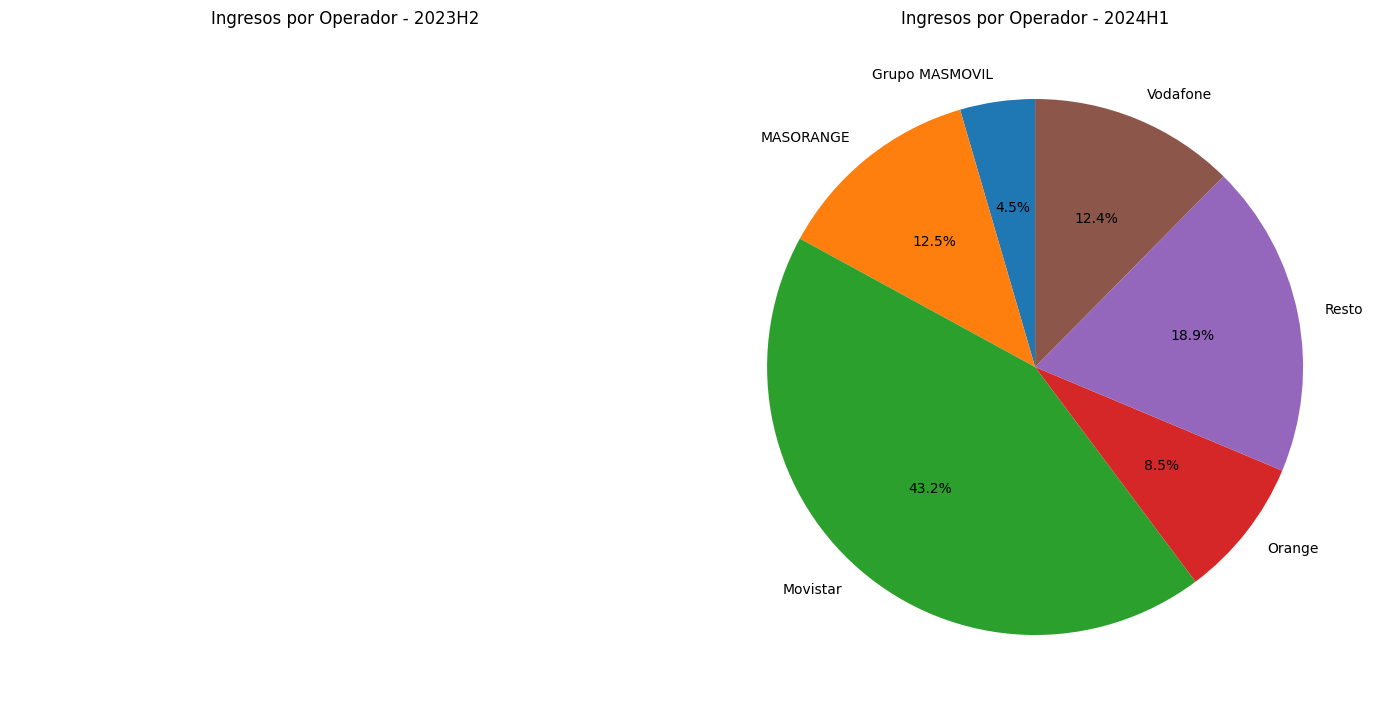

In [3]:
# Convert trimestre to datetime and extract year/quarter
df_filtered["year"] = df_filtered["trimestre"].dt.year
df_filtered["quarter"] = df_filtered["trimestre"].dt.quarter

# Correctly map quarters to semesters (1-2 -> H1, 3-4 -> H2)
df_filtered["semester"] = (
    df_filtered["year"].astype(str)
    + "H"
    + ((df_filtered["quarter"] > 2).astype(int) + 1).astype(str)
)

# Aggregate by semester and operator
df_semester_grouped = (
    df_filtered.groupby(["semester", "operador"])["ingresos_por_operador"]
    .sum()
    .reset_index()
)

# Filter for 2023H2 and 2024H1
specific_semesters = ["2023H2", "2024H1"]
specific_data = df_semester_grouped[
    df_semester_grouped["semester"].isin(specific_semesters)
]

# Pie charts for the specific semesters
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
for i, semester in enumerate(specific_semesters):
    pie_data_semester = specific_data[specific_data["semester"] == semester].set_index(
        "operador"
    )["ingresos_por_operador"]
    pie_data_semester.plot.pie(
        ax=axes[i], autopct="%1.1f%%", startangle=90, legend=False
    )
    axes[i].set_title(f"Ingresos por Operador - {semester}")
    axes[i].set_ylabel("")

plt.tight_layout()
plt.show()

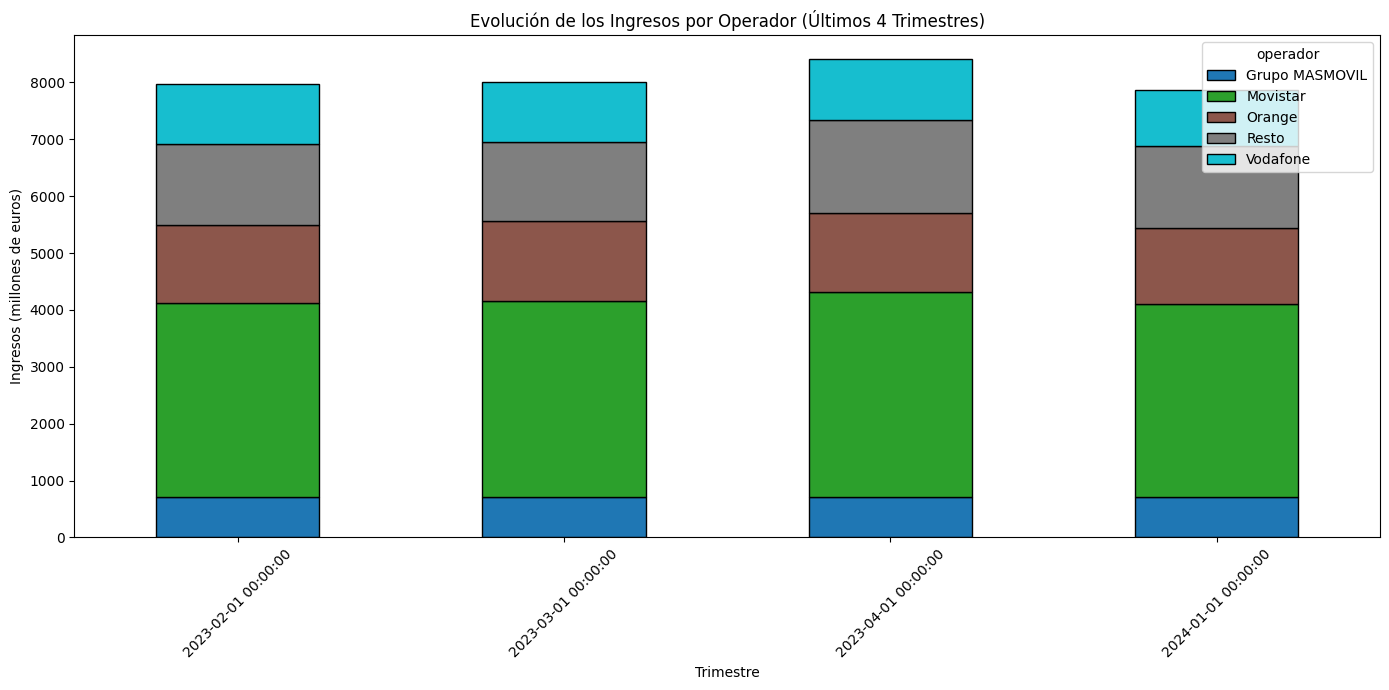

In [4]:
# Gráfico de barras de evolución trimestral (últimos 4 trimestres)
latest_quarters = df_filtered["trimestre"].unique()[1:5]
df_quarterly = df_filtered[df_filtered["trimestre"].isin(latest_quarters)]
df_evolution = (
    df_quarterly.groupby(["trimestre", "operador"])["ingresos_por_operador"]
    .sum()
    .unstack()
)

fig, ax = plt.subplots(figsize=(14, 7))
df_evolution.plot(kind="bar", stacked=True, ax=ax, colormap="tab10", edgecolor="black")
ax.set_title("Evolución de los Ingresos por Operador (Últimos 4 Trimestres)")
ax.set_ylabel("Ingresos (millones de euros)")
ax.set_xlabel("Trimestre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

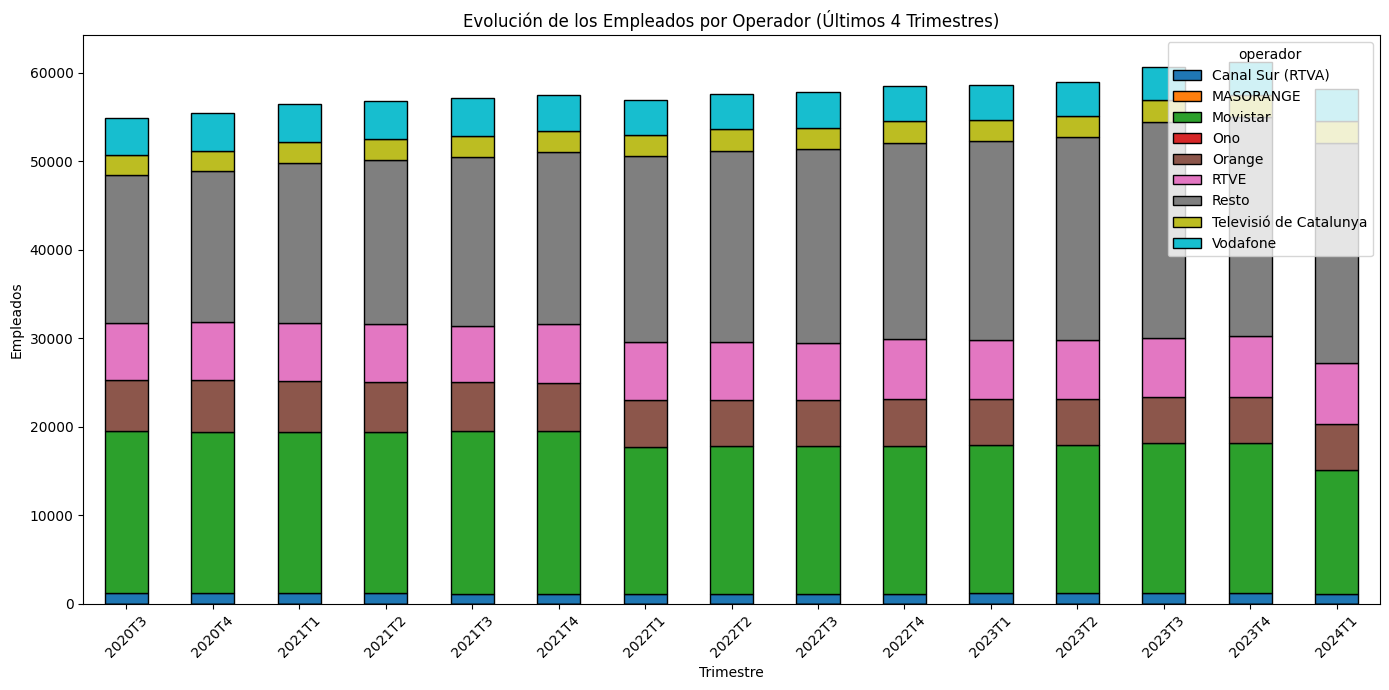

In [5]:
# Gráfico de barras semestral para empleados
employee_data = df[["trimestre", "operador", "empleados_por_operador"]].copy()

# delete empty empleados_por_operador
employee_data["empleados_por_operador"] = pd.to_numeric(
    employee_data["empleados_por_operador"], errors="coerce"
)
employee_data = employee_data.dropna(subset=["operador", "empleados_por_operador"])


df_evolution = (
    employee_data.groupby(["trimestre", "operador"])["empleados_por_operador"]
    .sum()
    .unstack()
)[-16:-1]
fig, ax = plt.subplots(figsize=(14, 7))
df_evolution.plot(kind="bar", stacked=True, ax=ax, colormap="tab10", edgecolor="black")
ax.set_title("Evolución de los Empleados por Operador (Últimos 4 Trimestres)")
ax.set_ylabel("Empleados")
ax.set_xlabel("Trimestre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

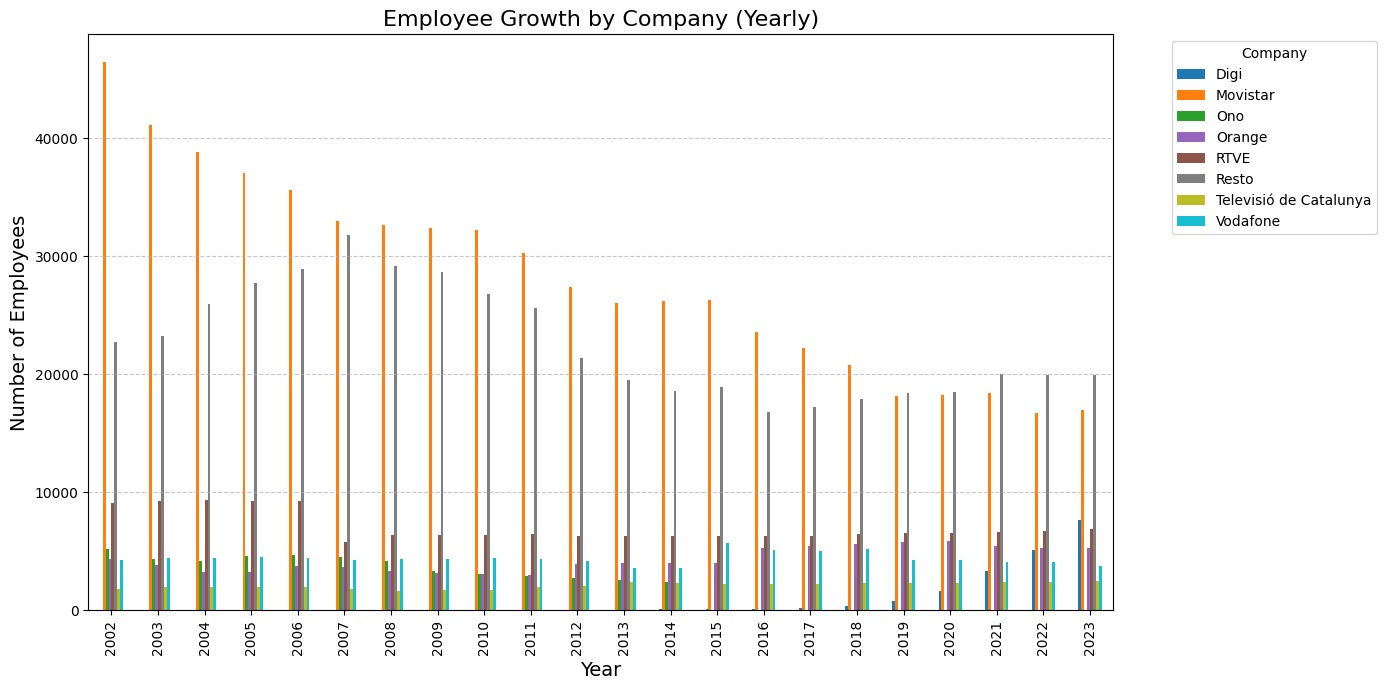

In [6]:
# Filter relevant data: year, company, and number of employees
employee_data = df_2[df_2["concepto"] == "Número de empleados"][
    ["anno", "operador", "empleados_por_operador"]
]

# Drop rows with null values in the 'empleados_por_operador' column
employee_data = employee_data.dropna()

# Convert data types
employee_data["anno"] = employee_data["anno"].astype(int)
employee_data["empleados_por_operador"] = employee_data[
    "empleados_por_operador"
].astype(int)

# Pivot data for visualization
pivot_data = employee_data.pivot(
    index="anno", columns="operador", values="empleados_por_operador"
)

# Plot the data
plt.figure(figsize=(12, 6))
pivot_data.plot(kind="bar", stacked=False, figsize=(14, 7), colormap="tab10")
plt.title("Employee Growth by Company (Yearly)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Employees", fontsize=14)
plt.legend(title="Company", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()


plt.show()

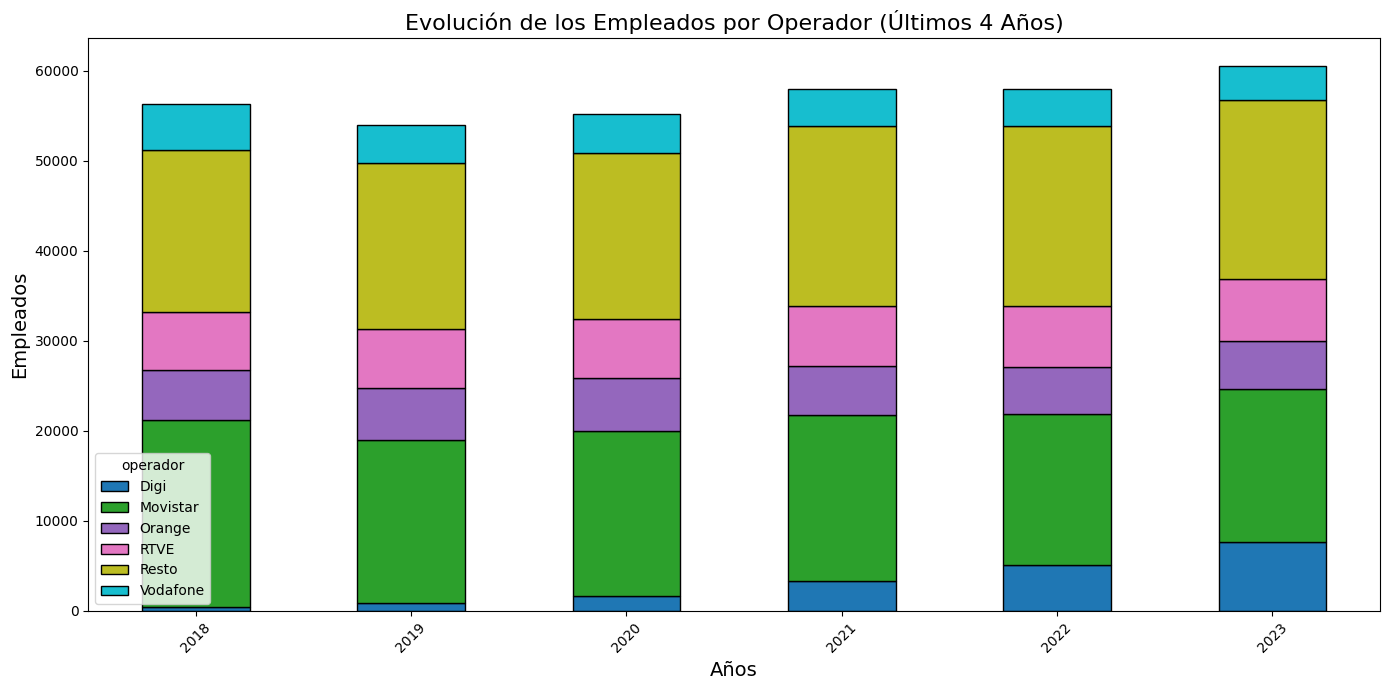

In [10]:
# Group and reshape the data for the plot
df_evolution = (
    employee_data.groupby(["anno", "operador"])["empleados_por_operador"]
    .sum()
    .unstack()
)[
    -6:
]  # Last 16 quarters

# delete Ono data and Televisió de Cataluña
df_evolution = df_evolution.drop(columns=["Ono", "Televisió de Catalunya"])

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(14, 7))
df_evolution.plot(kind="bar", stacked=True, ax=ax, colormap="tab10", edgecolor="black")
ax.set_title("Evolución de los Empleados por Operador (Últimos 4 Años)", fontsize=16)
ax.set_ylabel("Empleados", fontsize=14)
ax.set_xlabel("Años", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()


plt.show()